# The Battle of two Indian cities - Mumbai vs Chennai

#### Importing Libraries Required

In [4]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as BSoup
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!pip install geopy
from geopy.geocoders import Nominatim

#!pip install folium 
import folium # map rendering library

#!pip install geocoder
import geocoder # import geocoder

#!pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

#### Fetching the Geolocation details (Latitudes, Longitudes) of Mumbai and Chennai

In [5]:
def get_geolocation(address):
  loc = Nominatim().geocode(address)
  geolocation = dict()
  geolocation['latitude'] = loc.latitude
  geolocation['longitude'] = loc.longitude
  return geolocation

In [153]:
"""
Using Nominatim from geopy.geocoders to fetch GeoLocation data on the basis of 
Location string
"""
mb_loc = get_geolocation('Mumbai, India')
mb_geodata = dict()
mb_geodata['City'] = 'Mumbai'
mb_geodata['Latitude'] = mb_loc['latitude']
mb_geodata['Longitude'] = mb_loc['longitude']

ch_loc = get_geolocation('Chennai, India')
ch_geodata = dict()
ch_geodata['City'] = 'Chennai'
ch_geodata['Latitude'] = ch_loc['latitude']
ch_geodata['Longitude'] = ch_loc['longitude']

C:\Users\Abhishek\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


#### Using Foursquare Location API to fetch Nearby Locations

   _Initializing the basic Foursquare API parameters and Fetching Nearby Venues in the neighborhood_  
   __Please apply your own FourSquare API Credentials here:__  

In [156]:
CLIENT_ID = '**********************************'
CLIENT_SECRET = '***********************************'
VERSION = '20190302'

In [157]:
def getNearbyVenues(names, lat, lng, radius=5000):

  venues_list=[]
#   for name, lat, lng in zip(names, latitudes, longitudes):
  name = names.split(',')[0]
#   print(name)

  # create the API request URL
  url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
      CLIENT_ID, 
      CLIENT_SECRET, 
      VERSION, 
      lat, 
      lng, 
      radius, 
      LIMIT)

  # make the GET request
  results = requests.get(url).json()["response"]['groups'][0]['items']
#   print(results)

  # return only relevant information for each nearby venue
  venues_list.append([(

      v['venue']['name'], 
      str(v['venue']['location']['lat']), 
      str(v['venue']['location']['lng']),  
      v['venue']['categories'][0]['name']) for v in results])

  nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
  nearby_venues.columns = [
                'Venue', 
                'Latitude', 
                'Longitude', 
                'Venue Category']

  return(nearby_venues)

#### Fetching Data for Mumbai and Chennai:

In [158]:
mb_venues = getNearbyVenues(names=mb_geodata['City'], lat=mb_geodata['Latitude'], lng=mb_geodata['Longitude'])
ch_venues = getNearbyVenues(names=ch_geodata['City'], lat=ch_geodata['Latitude'], lng=ch_geodata['Longitude'])

#### 1. Grouping the above data on the basis of Venue Categories

In [159]:
mb_geoloc_groups = (mb_venues.groupby('Venue Category').apply(lambda x: [i for i in map(lambda p, q: (p,q), x.Latitude, x.Longitude)]).reset_index())
mb_geoloc_groups.rename(columns={0: 'Coordinates_Mumbai'}, inplace=True)
print(mb_geoloc_groups.head(3))
print(mb_geoloc_groups.shape)


ch_geoloc_groups = (ch_venues.groupby('Venue Category').apply(lambda y: [i for i in map(lambda p, q: (p,q), y.Latitude, y.Longitude)]).reset_index())
ch_geoloc_groups.rename(columns={0: 'Coordinates_Chennai'}, inplace=True)
print(ch_geoloc_groups.head(3))
print(ch_geoloc_groups.shape)

       Venue Category                                 Coordinates_Mumbai
0         Art Gallery           [(18.927606328364668, 72.8314638434005)]
1    Asian Restaurant  [(18.929590298584472, 72.83204264290254), (18....
2  Athletics & Sports          [(18.937691299778436, 72.83097627498172)]
(55, 2)
       Venue Category                                Coordinates_Chennai
0  African Restaurant          [(13.046236543084332, 80.25626732980982)]
1    Asian Restaurant  [(13.060795839982353, 80.24983283193629), (13....
2  Athletics & Sports          [(13.065539775908881, 80.25843386675812)]
(52, 2)


#### 2. Merging the geolocation data of Mumbai for each row of the grouped data

In [160]:
mb_venue_catg_grouped = mb_venues.groupby('Venue Category').count().reset_index()
mb_venue_groups = (mb_venues.groupby('Venue Category').apply(lambda x: ','.join(x.Venue)).reset_index())
mb_venue_grouped = (mb_venue_catg_grouped.sort_values('Venue', ascending=False))[['Venue Category', 'Venue']]

mb_venue_grouped.rename(columns={'Venue': 'Count_Mumbai'}, inplace=True)
mb_venue_groups.rename(columns={0: 'Venues_Mumbai'}, inplace=True)

mb_count_venues = pd.merge(mb_venue_groups, mb_venue_grouped, on="Venue Category", how="inner")

mb_count_data = pd.merge(mb_count_venues, mb_geoloc_groups, on="Venue Category", how="inner")
mb_count_data

,Venue Category,Venues_Mumbai,Count_Mumbai,Coordinates_Mumbai
0,Art Gallery,Jehangir Art Gallery,1,"[(18.927606328364668, 72.8314638434005)]"
1,Asian Restaurant,"Burma Burma,Pa Pa Ya (Colaba)",2,"[(18.929590298584472, 72.83204264290254), (18...."
2,Athletics & Sports,Bombay Gymkhana,1,"[(18.937691299778436, 72.83097627498172)]"
3,Bakery,"Yazdani Bakery,Dark Temptations",2,"[(18.93319143074909, 72.83359064269625), (18.9..."
4,Bar,"The Irish House,Gokul Restaurant and Bar",2,"[(18.927796700220078, 72.83229461732971), (18...."
5,Beach,Queen's Necklace,1,"[(18.933982645438288, 72.82389609019086)]"
6,Bookstore,"Kitab Khana,Oxford Bookstore",2,"[(18.932056629383982, 72.83177317437163), (18...."
7,Boutique,Sabyasachi,1,"[(18.926989753183356, 72.83318533588488)]"
8,Breakfast Spot,"The Nutcracker,Indigo Delicatessen",2,"[(18.9285089238906, 72.83368287546709), (18.92..."
9,Café,"Food for Thought,Kyani & Co.,Kala Ghoda Café,C...",9,"[(18.932030548104755, 72.83166719005116), (18...."


#### 3. Merging the geolocation data of Chennai for each row of the grouped data

In [161]:
ch_venue_catg_grouped = ch_venues.groupby('Venue Category').count().reset_index()
ch_venue_groups = (ch_venues.groupby('Venue Category').apply(lambda x: ','.join(x.Venue)).reset_index())
ch_venue_grouped = (ch_venue_catg_grouped.sort_values('Venue', ascending=False))[['Venue Category', 'Venue']]

ch_venue_grouped.rename(columns={'Venue': 'Count_Chennai'}, inplace=True)
ch_venue_groups.rename(columns={0: 'Venues_Chennai'}, inplace=True)

ch_count_venues = pd.merge(ch_venue_groups, ch_venue_grouped, on="Venue Category", how="inner")
ch_count_data = pd.merge(ch_count_venues, ch_geoloc_groups, on="Venue Category", how="inner")
ch_count_data

,Venue Category,Venues_Chennai,Count_Chennai,Coordinates_Chennai
0,African Restaurant,Nando's,1,"[(13.046236543084332, 80.25626732980982)]"
1,Asian Restaurant,"Nasi And Mee,Murugan Idli Shop",2,"[(13.060795839982353, 80.24983283193629), (13...."
2,Athletics & Sports,The Presidency Club,1,"[(13.065539775908881, 80.25843386675812)]"
3,Bar,"Blend - The High Energy Bar,Z The Tapas Bar & ...",2,"[(13.06158090339195, 80.26444806532172), (13.0..."
4,Beach,"Marina Beach | மெரினா கடற்கரை (Marina Beach),G...",3,"[(13.047662900808886, 80.2806979251197), (13.0..."
5,Bookstore,Higginbothams,1,"[(13.08318961077487, 80.27516784004308)]"
6,Café,"Nicky's Cafe & Fine Pastries,Amethyst,The Brew...",4,"[(13.063876670198082, 80.25980580677617), (13...."
7,Chinese Restaurant,Dynasty,1,"[(13.066879912143964, 80.2431017044096)]"
8,Chocolate Shop,Sandy's Chocolate Laboratory,1,"[(13.061069932713108, 80.24836782681334)]"
9,Clothing Store,"Lifestyle,Celio*",2,"[(13.058318372555929, 80.26482086940455), (13...."


#### 4. Combining the geolocation data of Mumbai and Chennai for each row of the grouped data

In [162]:
combined_count_data = pd.merge(mb_count_data, ch_count_data, on="Venue Category", how="inner")
combined_count_data

,Venue Category,Venues_Mumbai,Count_Mumbai,Coordinates_Mumbai,Venues_Chennai,Count_Chennai,Coordinates_Chennai
0,Asian Restaurant,"Burma Burma,Pa Pa Ya (Colaba)",2,"[(18.929590298584472, 72.83204264290254), (18....","Nasi And Mee,Murugan Idli Shop",2,"[(13.060795839982353, 80.24983283193629), (13...."
1,Athletics & Sports,Bombay Gymkhana,1,"[(18.937691299778436, 72.83097627498172)]",The Presidency Club,1,"[(13.065539775908881, 80.25843386675812)]"
2,Bar,"The Irish House,Gokul Restaurant and Bar",2,"[(18.927796700220078, 72.83229461732971), (18....","Blend - The High Energy Bar,Z The Tapas Bar & ...",2,"[(13.06158090339195, 80.26444806532172), (13.0..."
3,Beach,Queen's Necklace,1,"[(18.933982645438288, 72.82389609019086)]","Marina Beach | மெரினா கடற்கரை (Marina Beach),G...",3,"[(13.047662900808886, 80.2806979251197), (13.0..."
4,Bookstore,"Kitab Khana,Oxford Bookstore",2,"[(18.932056629383982, 72.83177317437163), (18....",Higginbothams,1,"[(13.08318961077487, 80.27516784004308)]"
5,Café,"Food for Thought,Kyani & Co.,Kala Ghoda Café,C...",9,"[(18.932030548104755, 72.83166719005116), (18....","Nicky's Cafe & Fine Pastries,Amethyst,The Brew...",4,"[(13.063876670198082, 80.25980580677617), (13...."
6,Chinese Restaurant,"Royal China,Golden Dragon",2,"[(18.938715239156295, 72.83293313173236), (18....",Dynasty,1,"[(13.066879912143964, 80.2431017044096)]"
7,Clothing Store,Zara,1,"[(18.932453310693468, 72.83204218319372)]","Lifestyle,Celio*",2,"[(13.058318372555929, 80.26482086940455), (13...."
8,Cricket Ground,"Wankhede Stadium,The Cricket Club Of India (CCI)",2,"[(18.938792382629718, 72.82594448102758), (18....",M A Chidambaram Stadium,1,"[(13.062830126112663, 80.27923923698869)]"
9,Dessert Shop,"Theobroma,Volga Paan Wala",2,"[(18.91929830684632, 72.82918453216553), (18.9...",Bombay Lassi,1,"[(13.066040282556875, 80.27122228359333)]"


#### 5. Performing Clustering on the aforeformed data using k-Means Clustering algorithm

In [163]:
k_cluster_num = 5
columns = ['Mumbai_Venue_Count', 'Chennai_Venue_Count']
data_temp = {'Mumbai_Venue_Count': combined_count_data['Count_Mumbai'], 'Chennai_Venue_Count': combined_count_data['Count_Chennai']}

data_temp_df = pd.DataFrame(data_temp, columns=columns)
print(data_temp_df)
k_means_count = KMeans(n_clusters=k_cluster_num, random_state=0).fit(data_temp_df)
print(k_means_count.labels_)

    Mumbai_Venue_Count  Chennai_Venue_Count
0                    2                    2
1                    1                    1
2                    2                    2
3                    1                    3
4                    2                    1
5                    9                    4
6                    2                    1
7                    1                    2
8                    2                    1
9                    2                    1
10                   2                    1
11                   1                    3
12                   1                    1
13                   4                    9
14                   4                    4
15                   9                   19
16                   2                    3
17                   2                    1
18                   1                    1
19                   1                    1
20                   1                    2
21                   1          

#### 6. Merging the Cluster labels with the Count data

In [164]:
# Creating a DataFrame with both Cluster-values and top-10 venues of each neighborhood
count_combined = combined_count_data
count_combined['Cluster Labels'] = k_means_count.labels_
print(count_combined.head(3))

       Venue Category                             Venues_Mumbai  Count_Mumbai  \
0    Asian Restaurant             Burma Burma,Pa Pa Ya (Colaba)             2   
1  Athletics & Sports                           Bombay Gymkhana             1   
2                 Bar  The Irish House,Gokul Restaurant and Bar             2   

                                  Coordinates_Mumbai  \
0  [(18.929590298584472, 72.83204264290254), (18....   
1          [(18.937691299778436, 72.83097627498172)]   
2  [(18.927796700220078, 72.83229461732971), (18....   

                                      Venues_Chennai  Count_Chennai  \
0                     Nasi And Mee,Murugan Idli Shop              2   
1                                The Presidency Club              1   
2  Blend - The High Energy Bar,Z The Tapas Bar & ...              2   

                                 Coordinates_Chennai  Cluster Labels  
0  [(13.060795839982353, 80.24983283193629), (13....               0  
1          [(13.0655397

#### 7. Grouping and combining each returned venue and location of Mumbai

In [165]:
# onehot-encoding the venues-data:
mb_venues_onehot = pd.get_dummies(mb_venues[['Venue Category']], prefix='', prefix_sep='')

mb_venues_onehot['Venue Category'] = mb_venues['Venue Category']

mb_venues_grouped_mean = mb_venues_onehot.groupby('Venue Category').mean().reset_index()

mb_mean_data = pd.merge(mb_venues_grouped_mean, mb_geoloc_groups, on="Venue Category", how="inner")

mb_venues_mean_temp = mb_venues_grouped_mean.drop('Venue Category', 1)
k_means_avg_mb = KMeans(n_clusters=k_cluster_num, random_state=0).fit(mb_venues_mean_temp)
mb_mean_merged = mb_venues_grouped_mean
mb_mean_merged['Cluster Labels'] = k_means_avg_mb.labels_
mb_mean_merged = pd.merge(mb_mean_merged[['Venue Category', 'Cluster Labels']], mb_venues_onehot, on='Venue Category', how='inner')
mb_mean_merged = pd.merge(mb_mean_merged, mb_venues[['Venue Category', 'Venue', 'Latitude', 'Longitude']], on='Venue Category', how='inner')
mb_mean_merged.drop_duplicates(inplace=True)

#### 8.Grouping and combining each returned venue and location of Chennai

In [166]:
# onehot-encoding the venues-data:
ch_venues_onehot = pd.get_dummies(ch_venues[['Venue Category']], prefix='', prefix_sep='')

ch_venues_onehot['Venue Category'] = ch_venues['Venue Category']
ch_venues_grouped_mean = ch_venues_onehot.groupby('Venue Category').mean().reset_index()

ch_mean_data = pd.merge(ch_venues_grouped_mean, ch_geoloc_groups, on="Venue Category", how="inner")

ch_venues_mean_temp = ch_venues_grouped_mean.drop('Venue Category', 1)
k_means_avg_ch = KMeans(n_clusters=k_cluster_num, random_state=0).fit(ch_venues_mean_temp)
ch_mean_merged = ch_venues_grouped_mean
ch_mean_merged['Cluster Labels'] = k_means_avg_ch.labels_
ch_mean_merged = pd.merge(ch_mean_merged[['Venue Category', 'Cluster Labels']], ch_venues_onehot, on='Venue Category', how='inner')
# ch_mean_merged[['Venue Category', 'Cluster Labels']]
ch_mean_merged = pd.merge(ch_mean_merged, ch_venues[['Venue Category', 'Venue', 'Latitude', 'Longitude']], on='Venue Category', how='inner')
ch_mean_merged.drop_duplicates(inplace=True)

#### 9. Visualizing all the returned venues of Mumbai and Chennai

##### Creating a function to visualize all the venues of Mumbai and Chennai using Folium Maps

In [167]:
def create_city_map(merged_data, geoloc_data, common_data):
  base_lat = geoloc_data['Latitude']
  base_lng = geoloc_data['Longitude']
  map_clusters = folium.Map(location=[base_lat, base_lng], zoom_start=15, tiles = "Stamen Terrain")

  # set color scheme for the clusters
  x = np.arange(k_cluster_num)
  ys = [i+x+(i*x)**2 for i in range(k_cluster_num)]
  colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
  rainbow = [colors.rgb2hex(i) for i in colors_array]

  # add markers to the map
  markers_colors = []
  for lat, lon, poi, cluster, categ in zip(merged_data['Latitude'], merged_data['Longitude'], merged_data['Venue'], merged_data['Cluster Labels'], merged_data['Venue Category']):
    label = folium.Popup('{} ({}) - Cluster {}'.format(str(poi), categ, str(cluster)), parse_html=True)
    folium.CircleMarker(
        [float(lat), float(lon)],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

  return map_clusters

#### Map of Popular Venues in Mumbai

In [168]:
mb_overall_map = create_city_map(mb_mean_merged, mb_geodata, count_combined)
mb_overall_map

#### Map of Popular Venues in Chennai

In [169]:
ch_overall_map = create_city_map(ch_mean_merged, ch_geodata, count_combined)
ch_overall_map

#### 10. Creating a function to display each venue from the combined count data using Folium Maps

In [170]:
""" 
Creating map of Cities's Neighborhood using Folium
"""

# defining the Folium Map in a function
def create_map(city_data, geoloc_data):
  base_lat = float(geoloc_data['Latitude'])
  base_lng = float(geoloc_data['Longitude'])
  map_clusters = folium.Map(location=[base_lat, base_lng], zoom_start=16 ,tiles = "Stamen Terrain")

  # set color scheme for the clusters

  rainbow = ['#F84583', '#4868F7', '#53DEE8', '#00F950', '#F9FA20']
  geodata_param = city_data['Coordinates_{}'.format(geoloc_data['City'])]
  venue_param = city_data['Venues_{}'.format(geoloc_data['City'])]

  # add markers to the map
  markers_colors = []

  for geo_data, venues, cluster, categ in zip(geodata_param, venue_param, city_data['Cluster Labels'], city_data['Venue Category']):
#     print('{}: [{}] - cluster {}'.format(venues, geo_data, cluster))
    for geoloc, poi in zip(geo_data, venues.split(',')):
#       print('{1}: {0}'.format(geoloc, poi))
      label = folium.Popup(str(poi) + ' ( {} ) - Cluster {}'.format(categ, str(cluster)), parse_html=True)
      folium.CircleMarker(
          [float(geoloc[0]), float(geoloc[1])],
          radius=5,
          popup=label,
          color=rainbow[cluster-1],
          fill=True,
          fill_color=rainbow[cluster-1],
          fill_opacity=1).add_to(map_clusters)
  return map_clusters

#### Displaying Mumbai Venues

In [171]:
mb_cluster_map = create_map(count_combined, mb_geodata)
mb_cluster_map

### Cluster Analysis for Mumbai

#### First Cluster

In [174]:
first_cluster = count_combined.loc[count_combined['Cluster Labels'] == 0, count_combined.columns[[0] + list(range(1, count_combined.shape[1]))]]
print(first_cluster.shape[0])
mb_first_cluster = create_map(first_cluster, mb_geodata)
mb_first_cluster

19


#### Second Cluster


In [175]:
second_cluster = count_combined.loc[count_combined['Cluster Labels'] == 1, count_combined.columns[[0] + list(range(1, count_combined.shape[1]))]]
print(len(second_cluster))
mb_second_cluster = create_map(second_cluster, mb_geodata)
mb_second_cluster

1


#### Third Cluster

In [176]:
third_cluster = count_combined.loc[count_combined['Cluster Labels'] == 2, count_combined.columns[[0] + list(range(1, count_combined.shape[1]))]]
print(len(third_cluster))
mb_third_cluster = create_map(third_cluster, mb_geodata)
mb_third_cluster

1


#### Fourth Cluster

In [177]:
fourth_cluster = count_combined.loc[count_combined['Cluster Labels'] == 3, count_combined.columns[[0] + list(range(1, count_combined.shape[1]))]]
print(len(fourth_cluster))
mb_fourth_cluster = create_map(fourth_cluster, mb_geodata)
mb_fourth_cluster

1


#### Fifth Cluster

In [178]:
fifth_cluster = count_combined.loc[count_combined['Cluster Labels'] == 4, count_combined.columns[[0] + list(range(1, count_combined.shape[1]))]]
print(fifth_cluster.shape[0])
mb_fifth_cluster = create_map(fifth_cluster, mb_geodata)
mb_fifth_cluster

4


### Displaying Chennai Venues

In [179]:
ch_cluster_map = create_map(count_combined, ch_geodata)
ch_cluster_map

### Analysing Clusters of London

#### First Cluster

In [180]:
first_cluster = count_combined.loc[count_combined['Cluster Labels'] == 0, count_combined.columns[[0] + list(range(1, count_combined.shape[1]))]]
print(first_cluster.shape[0])
ch_first_cluster = create_map(first_cluster, ch_geodata)
ch_first_cluster

19


#### Second Cluster

In [181]:
second_cluster = count_combined.loc[count_combined['Cluster Labels'] == 1, count_combined.columns[[0] + list(range(1, count_combined.shape[1]))]]
print(second_cluster.shape[0])
ch_second_cluster = create_map(second_cluster, ch_geodata)
ch_second_cluster

1


#### Third Cluster

In [182]:
third_cluster = count_combined.loc[count_combined['Cluster Labels'] == 2, count_combined.columns[[0] + list(range(1, count_combined.shape[1]))]]
print(third_cluster.shape[0])
ch_third_cluster = create_map(third_cluster, ch_geodata)
ch_third_cluster

1


#### Fourth Cluster

In [183]:
fourth_cluster = count_combined.loc[count_combined['Cluster Labels'] == 3, count_combined.columns[[0] + list(range(1, count_combined.shape[1]))]]
print(fourth_cluster.shape[0])
ch_fourth_cluster = create_map(fourth_cluster, ch_geodata)
ch_fourth_cluster

1


#### Fifth Cluster

In [184]:
fifth_cluster = count_combined.loc[count_combined['Cluster Labels'] == 4, count_combined.columns[[0] + list(range(1, count_combined.shape[1]))]]
print(fifth_cluster.shape[0])
ch_fifth_cluster = create_map(fifth_cluster, ch_geodata)
ch_fifth_cluster

4


## __Visualizations__

#### 1. Bar charts to analyze frequency of occurrences of venue categories in both the cities

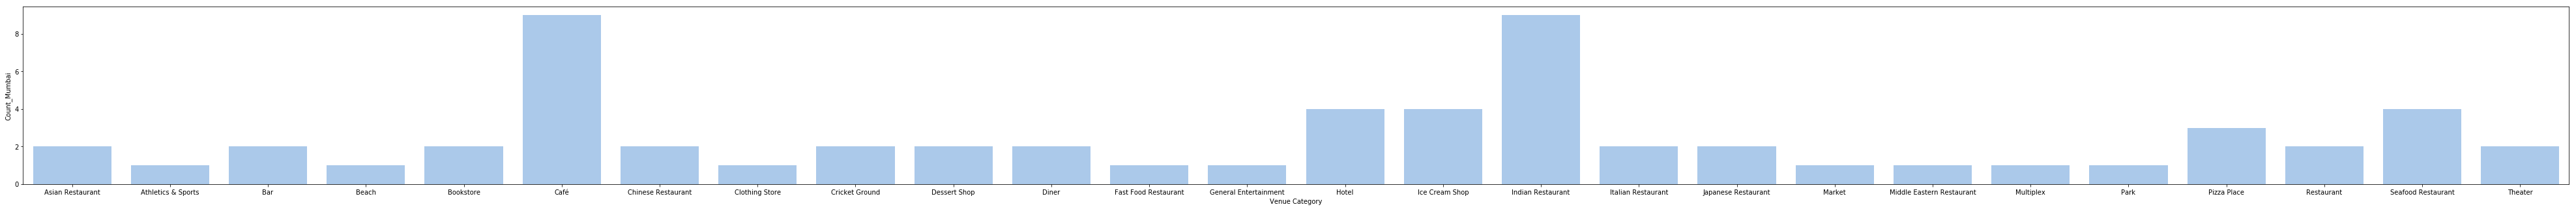

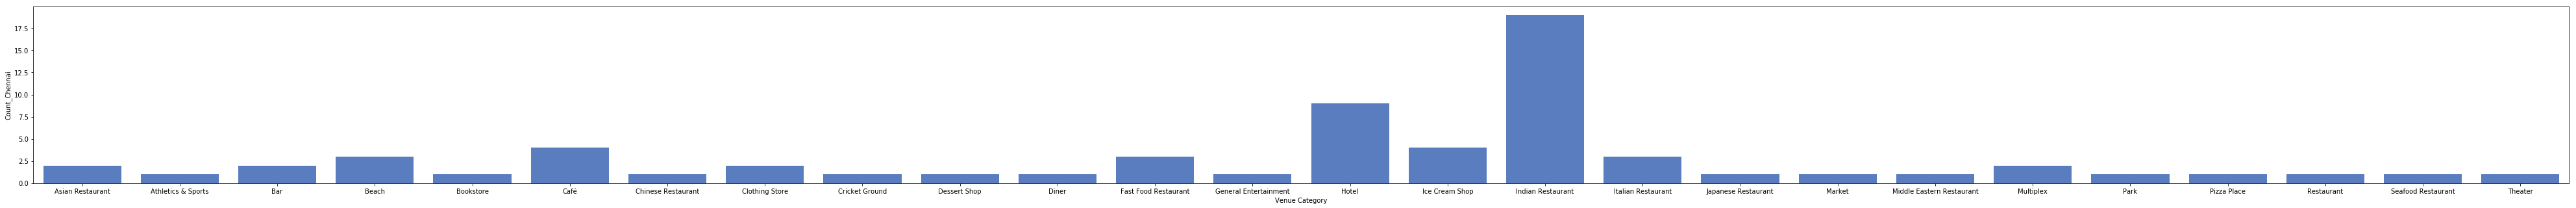

In [185]:
plt.figure(figsize=(70,5))
sns.set_color_codes("pastel")
sns.barplot(x='Venue Category', y='Count_Mumbai', data=count_combined, color='b', label='Mumbai City', )
# nyc_plot.set_xticklabels(labels=list(count_combined['Venue Category']), rotation=40)
# london_plot.set_xticklabels(labels=list(count_combined['Venue Category']), rotation=40)

plt.figure(figsize=(70,5))
sns.set_color_codes("muted")
sns.barplot(x='Venue Category', y='Count_Chennai', data=count_combined, color='b', label='Chennai City')

#### 2. Constructing a Strip plot for a cumulative visualization of occurrence-frequencies

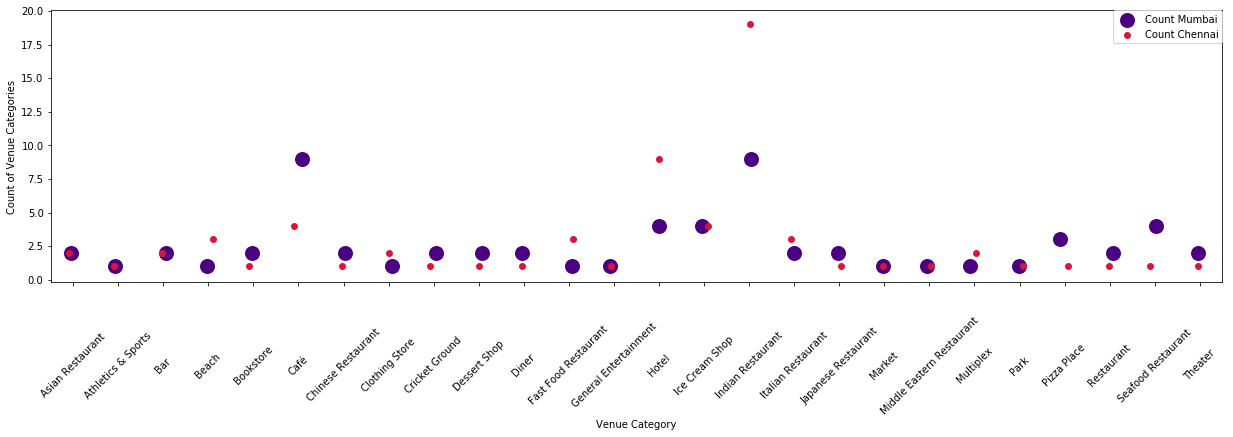

In [186]:
handles = list()
labels = list()
plt.figure(figsize=(21, 5))

sns.set_color_codes("pastel")

ax = sns.stripplot(x='Venue Category', y='Count_Mumbai', data=count_combined,palette=['indigo'],size=15, label='Count Mumbai')

handle, label = ax.get_legend_handles_labels()
handles.append(handle[0])
labels.append(label[0])

ax.set_xticklabels(list(count_combined['Venue Category']), rotation = 45, va="center", position=(0,-0.28))

sns.set_color_codes("muted")

ax1 = sns.stripplot(x='Venue Category', y='Count_Chennai', data=count_combined, palette=['crimson'], size=7, label='Count Chennai')

handle1, label1 = ax1.get_legend_handles_labels()

handles.append(handle1[len(handle)+1])
labels.append(label1[len(label)+1])

plt.ylabel('Count of Venue Categories')

plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.)